# Using Gradient Boosting Trees to classify lidar data

This tutorial covers one of the many commonly used algorithms for classification. We use Gradient Boosting Trees from the lidar statistical coverage data in order to classify cloud conditions from pre-labelled data. Gradient boosting trees are developed by first finding the decision tree that minimizes the difference between the predicted values and true values given a set of input data. Then, until the loss is minimized, an ensemble of trees is developed whose results are added together to make the classification. In the example below, if we have a young boy as an input to the tree, we will know that he is under 20 years old, and, in this case, plays a lot of Minecraft. So we would add the positive tree values for "under 20" and "uses computer daily" together in both trees below. While such explicit labels are not as visible in real life gradient boosting trees, decision trees based on various features in the input space are developed similar to below with their results added together.

![Gradient Boosting Tree example](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png)

Credit: XGBoost developers

This notebook shows an example from a recent paper that looks at various machine learning algorithms to classify lidar data into clear and cloudy conditions. For more information about this study, see:

Jackson, R. C., and Coauthors, 2023: ARMing the Edge: Designing Edge Computing–Capable Machine Learning Algorithms to Target ARM Doppler Lidar Processing. Artif. Intell. Earth Syst., 2, 220062, https://doi.org/10.1175/AIES-D-22-0062.1. 

In this study, an XGBoost-based classifier was capable of identifying most clear air time periods correctly. However, a CNN-based model outperformed the XGBoost model's capability. However, this still shows a real world example of a machine learning model that has been applied in the literature and therefore is a good exercise for the student that can fit within an hour short course.

In [109]:
import xarray as xr
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK
%matplotlib inline

Let's load the input data again.

In [6]:
my_ds = xr.open_dataset('coverage_and_labels.nc')

In [7]:
feature_list = []
thresholds = [0.1, 0.5, 1, 2]
for c in thresholds:
    cf = float(c)
    feature_list.append('stddevgt%.6f' % cf)
print(feature_list)
print(my_ds)

['stddevgt0.100000', 'stddevgt0.500000', 'stddevgt1.000000', 'stddevgt2.000000']
<xarray.Dataset> Size: 3GB
Dimensions:                     (time: 11805, range: 199, snr_bins: 49,
                                 vel_bins: 79)
Coordinates:
  * time                        (time) datetime64[ns] 94kB 2017-07-31T18:01:1...
  * snr_bins                    (snr_bins) float64 392B 0.0 1.0 ... 47.0 48.0
  * vel_bins                    (vel_bins) float64 632B -20.0 -19.5 ... 19.0
Dimensions without coordinates: range
Data variables: (12/20)
    snrgt0.100000               (time, range) float64 19MB ...
    snr_hist                    (time, range, snr_bins) float64 921MB ...
    vel_hist                    (time, range, vel_bins) float64 1GB ...
    snrgt0.500000               (time, range) float64 19MB ...
    snrgt1.000000               (time, range) float64 19MB ...
    snrgt2.000000               (time, range) float64 19MB ...
    ...                          ...
    stddevgt1.000000       

Gradient boosting trees have numerous hyperparameters that need to be determined. 
   * eta: Step size shrinkage used to prevent overfitting. This is the factor by which the weights are shrinked by after each boosting round. Adjust this to prevent overfitting.
   * gamma: Minimum loss reduction required to make a new leaf on the tree
   * max_depth: The maximum depth of the tree
   * num_rounds: The number of boosting rounds to use
   * colsample_bytree: The percentage of the data columns (i.e. samples) that are randomly sampled for each boosting round.
   * subsample: The fraction of data that is subsampled before the tree is grown.

In order to automatically determine these parameters, we will utilize a tool called hyperopt. Hyperopt will perform a Bayesian Optimization algorthm that finds the hyperparameters that minimize the training loss. The user must specify the range of hyperparameters for hyperopt to include in its search. In this example, hyperopt is searching through the following space of hyperparameters.


In [68]:
params = {'eta': hp.loguniform('eta', np.log(0.0001), np.log(0.1)),   # Can only be 0 to 1
            'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]), # Integers 3-13
            'num_rounds': hp.choice('num_rounds',
                  np.arange(0, 2000, 100, dtype='int')),    # Number of boosting rounds (0:2000:100)
            'gamma': hp.uniform('gamma', 0, 10),  # Gamma can be a float from 0 to 10
            'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1),  # A float from 0.4 to 1
            'subsample': hp.uniform('subsample', 0.6, 1),  # A float from 0.6 to 1 chosen from a uniform distribution
            }


Now we need to load the data and convert it to xgboost's [DMatrix](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.DMatrix). The DMatrix object contains the input data, its labels, and a label for each feature. To convert a NumPy array *x* of *n_samples* by *n_features* and its labels *y* to a DMatrix is done by simply doing `dmat = xgb.DMatrix(x, label=y)` You can also specify the

In [185]:
x = np.concatenate([my_ds[x].values[:, :100] for x in feature_list], axis=1)
labels = my_ds['labels'].values
feature_labels = []
for feat in feature_list:
    for i in range(len(my_ds.range_bins[0,:100].values)):
        feature_labels.append('%s%d' % (feat, my_ds.range_bins[0, i]))

valid = np.where(labels > -1)[0]

# Combine cloudy and rainy into one label
labels[labels > 1] = 1
x = x[valid, :]
labels = labels[valid]
print('%d valid points' % len(labels))

# Split into testing and training
x_train, x_test, y_train, y_test = train_test_split(x, labels, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=feature_labels)
dtest = xgb.DMatrix(x_test, label=y_test, feature_names=feature_labels)
dall = xgb.DMatrix(x, label=labels, feature_names=feature_labels)

11489 valid points


First, we find the hyperparamters by defining the objective function that returns the metric that we wish to have minimized in the hyperparameter search. In this example, we are looking to minimize the training loss among all five folds of a 5-fold cross-validation.

In [70]:
# This takes a while to run, for the tutorial use the pre-calculated hyperparameters
def objective(x):
    params = {'eta': x['eta'],
              'max_depth': x['max_depth'],
              'num_parallel_tree': 1,
              'objective': 'multi:softmax',
              'num_class': 2,
              'colsample_bytree': x['colsample_bytree'],
              'subsample': x['subsample'],
              'gamma': x['gamma'],
              'eval_metric': "merror",
              'verbosity': 0}

    res = xgb.cv(params, dall, nfold=5,
                 num_boost_round=x['num_rounds'])
    try:
        return {'loss': res['test-merror-mean'].min(), 'status': STATUS_OK}
    except KeyError:
        return {'loss': 99999999., 'status': STATUS_OK}
trials = Trials()
best = fmin(objective, space=params, algo=tpe.suggest, max_evals=10,
         trials=trials)
best

100%|██████| 10/10 [04:49<00:00, 28.93s/trial, best loss: 0.23639980706662075]


{'colsample_bytree': 0.7068731317195411,
 'eta': 0.009095503785373604,
 'gamma': 0.2080660215044472,
 'max_depth': 8,
 'num_rounds': 4,
 'subsample': 0.9248043820882668}

In [156]:
# Pre-calculated best parameters from hyperopt with 10 model trainings
params = {'max_depth': 8,
          'colsample_bytree': 0.7068731317195411,
          'subsample': 0.9248043820882668,
          'eta': 0.009095503785373604,
          'gamma': 0.2080660215044472,
          'num_parallel_tree': 1,
          'objective': 'multi:softmax',
          'eval_metric': "merror",
          'num_class': 2,
          'verbosity': 1}

We now start the training with `xgb.train` using the code snippet below. In this training, we will implement a technique called early stopping that stops the training if the testing error has not improved within 10 iterations. This helps to prevent overfitting that occurrs when there are too many boosting rounds on the training data.

In [186]:
num_rounds = 1000
# Early stopping
print("Training...")
bst = xgb.train(params, dtrain, num_boost_round=num_rounds, 
                    evals=[(dtest, 'test')], early_stopping_rounds=100)

Training...
[0]	test-merror:0.26384
[1]	test-merror:0.26453
[2]	test-merror:0.26453
[3]	test-merror:0.26558
[4]	test-merror:0.26453
[5]	test-merror:0.26384
[6]	test-merror:0.26279
[7]	test-merror:0.26070
[8]	test-merror:0.25966
[9]	test-merror:0.25896
[10]	test-merror:0.25827
[11]	test-merror:0.25757
[12]	test-merror:0.25966
[13]	test-merror:0.26036
[14]	test-merror:0.26036
[15]	test-merror:0.26070
[16]	test-merror:0.26175
[17]	test-merror:0.26175
[18]	test-merror:0.26244
[19]	test-merror:0.26244
[20]	test-merror:0.26244
[21]	test-merror:0.26175
[22]	test-merror:0.26175
[23]	test-merror:0.26175
[24]	test-merror:0.26175
[25]	test-merror:0.26140
[26]	test-merror:0.26175
[27]	test-merror:0.26210
[28]	test-merror:0.26070
[29]	test-merror:0.26105
[30]	test-merror:0.26210
[31]	test-merror:0.26244
[32]	test-merror:0.26244
[33]	test-merror:0.26175
[34]	test-merror:0.26105
[35]	test-merror:0.26140
[36]	test-merror:0.26175
[37]	test-merror:0.26140
[38]	test-merror:0.26175
[39]	test-merror:0.2610

Let's take our model predictions to evaluate the testing accuracy.

In [187]:
y_predict = bst.predict(dtest)
y_all_predict = bst.predict(dall)
y_train_predict = bst.predict(dtrain)

One way to look at testing accuracy is to look at confusion matrices. A confusion matrix shows all of the time periods when the true and prediced label are the same and during what time periods they are different. Using accuracy alone could be misleading, especially for imbalanced datasets like this one. Therefore, it is crucial to also examine the confusion matrix of model predictions.

As we can see here, although we have 75.1% accuracy, the confusion matrix below shows that we are classifying clear air conditions correctly 94.4% of the time and all truly cloud conditions correctly 34.1% of the time. 

Accuracy: 0.7514792899408284
Clear air correctly classified: 0.9409669211195929
Cloud/Rainy correctly classified: 0.34140969162995594


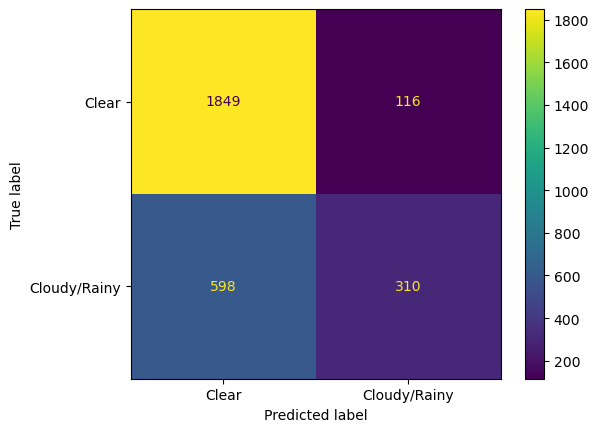

In [188]:
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    display_labels=["Clear", "Cloudy/Rainy"])

disp.plot()
print("Accuracy: " + str(accuracy_score(y_predict, y_test)))
print("Clear air correctly classified: " + str(cm[0,0]/(cm[0,0] + cm[0,1])))
print("Cloud/Rainy correctly classified: " + str(cm[1,1]/(cm[1,0] + cm[1,1])))

Recall and precision are better metrics for determining how well a model classifies true positives and true negative for imbalanced datasets. Precision is the ratio of true positives to the total number of positives:

$Recall = \frac{True\ Positives}{True\ Positives + False\ Negatives}$

Precision is the percentage of correctly classified positives to all positive classifications:

$Precision = \frac{True\ Positives}{True\ Positives + False\ Positives}$

In this case, a positive classification is "Cloudy/Rainy". In the below example, we see that we have recall and precision scores of 0.42 and 0.73. This shows that, if a profile is Clear, then it will be identified as such rather well. However, the algorithm has issues identifying cloudy cases as shown by the low recall score.

$F1-score = \frac{True\ Positives}{True\ Positives + 0.5*(False\ Positives + False\ Negatives)}$

There is usually a tradeoff between trying to optimize recall for a model. As a model is more optimized for recall, this may create more false positives, and hence lower precision. The F1-score, a number from 0 to 1, shows how well of a balance is struck between recall and precision. The closer the F1-score is to 1, the better this balance. In this example, F1-score is 0.50, showing suboptimal balance between recall and precision. This model is very good at identifying true Cloudy/Rainy cases when they exist, but also has an issue of mis-classifying Clear cases as Cloudy.

In [189]:
recall = recall_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
f_score = f1_score(y_test, y_predict)
print("Recall = " + str(recall))
print("Precision = " +  str(precision))
print("F1-score = " + str(f_score))

Recall = 0.34140969162995594
Precision = 0.7276995305164319
F1-score = 0.46476761619190404


## Mitigating training biases in imbalanced data

This final section will cover basic techniques for mitigating training biases on imbalanced datasets. 

Training can be greatly affected by class imbalances. As we can see here, the clear cases outnumber the cloudy by about 4:1. Therefore, we face a risk of the data being overfit on the clear cases if we were to train the model on the original data. This can be manifesting itself in classifying too many Clear cases as Cloudy. One way to mitigate these issues is to use Oversampling. Oversampling will randomly draw, with replacement, the number of samples in the majority class from the minority class so that the two classes are of equal size. Undersampling does just the opposite, drawing the number of samples in the minority class randomly from the majority class to get the two classes to be of the same size.

[Imbalanced Learn](https://imbalanced-learn.org/stable/) thankfully provides an easy to use API for doing Over- and Undersampling so that tihs can be done with two lines of code. We will use Imbalanced Learn's RandomOverSampler to do the Oversampling.

In [190]:
# Do oversampling of the clear/cloudy class
ros = RandomOverSampler()
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)
# Store new data for training
dtrain = xgb.DMatrix(x_train_ros, label=y_train_ros, feature_names=feature_labels)

Then we retrain the model.

In [191]:
num_rounds = 1500
# Early stopping
print("Training...")
bst = xgb.train(params, dtrain, num_boost_round=num_rounds, 
                    evals=[(dtest, 'test')], early_stopping_rounds=100)

Training...
[0]	test-merror:0.27845
[1]	test-merror:0.27811
[2]	test-merror:0.27706
[3]	test-merror:0.27358
[4]	test-merror:0.27637
[5]	test-merror:0.27115
[6]	test-merror:0.27010
[7]	test-merror:0.26975
[8]	test-merror:0.26975
[9]	test-merror:0.27115
[10]	test-merror:0.27184
[11]	test-merror:0.27115
[12]	test-merror:0.27115
[13]	test-merror:0.26975
[14]	test-merror:0.27149
[15]	test-merror:0.27219
[16]	test-merror:0.27323
[17]	test-merror:0.27080
[18]	test-merror:0.27010
[19]	test-merror:0.26906
[20]	test-merror:0.26766
[21]	test-merror:0.26697
[22]	test-merror:0.26523
[23]	test-merror:0.26662
[24]	test-merror:0.26662
[25]	test-merror:0.26627
[26]	test-merror:0.26558
[27]	test-merror:0.26488
[28]	test-merror:0.26627
[29]	test-merror:0.26662
[30]	test-merror:0.26627
[31]	test-merror:0.26697
[32]	test-merror:0.26766
[33]	test-merror:0.26627
[34]	test-merror:0.26558
[35]	test-merror:0.26523
[36]	test-merror:0.26418
[37]	test-merror:0.26384
[38]	test-merror:0.26558
[39]	test-merror:0.2638

Let's look at how the metrics have changed when using Oversampling. We maintain 74.7% accuracy overall. This time, 89.5% of the Clear air cases are classified correctly and 41.9% of the cloudy cases are classified correctly. We have slightly better performance in identifying both clear and cloudy cases.

Accuracy: 0.7452140619561434
Clear air correctly classified: 0.8956743002544529
Cloud/Rainy correctly classified: 0.4196035242290749


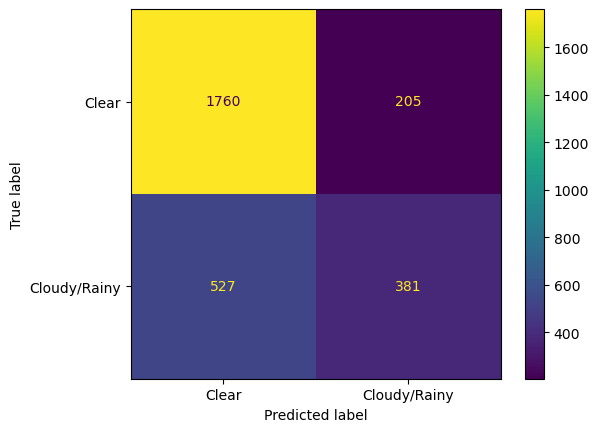

In [192]:
y_predict = bst.predict(dtest)
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    display_labels=["Clear", "Cloudy/Rainy"])

disp.plot()
print("Accuracy: " + str(accuracy_score(y_test, y_predict)))
print("Clear air correctly classified: " + str(cm[0,0]/(cm[0,0] + cm[0,1])))
print("Cloud/Rainy correctly classified: " + str(cm[1,1]/(cm[1,0] + cm[1,1])))

The recall, precision, and F1-score show a slightly more balanced model that has fewer false Cloudy cases.

In [193]:
recall = recall_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
f_score = f1_score(y_test, y_predict)
print("Recall = " + str(recall))
print("Precision = " +  str(precision))
print("F1-score = " + str(f_score))

Recall = 0.4196035242290749
Precision = 0.6501706484641638
F1-score = 0.5100401606425703


Now let's try random undersampling.

In [197]:
rus = RandomUnderSampler()
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
dtrain = xgb.DMatrix(x_train_rus, label=y_train_rus, feature_names=feature_labels)
num_rounds = 1000
# Early stopping
print("Training...")
bst = xgb.train(params, dtrain, num_boost_round=num_rounds, 
                    evals=[(dtest, 'test')], callbacks=[early_stop], early_stopping_rounds=100)

Training...
[0]	test-merror:0.28785


Random undersampling results in reduced accuracy and a less well-balanced model, but better performance in identifying the Cloudy time periods. The lesson here is that the model that you are training should be tuned to your application and what's most important for that. In this case, if you are interested in studying boundary layer dynamics from the lidar, then correctly identifying clear air cases is most important. However, if we are studying clouds and precipitation, then we would want to prioritize identifying the Cloudy cases correctly when making these tradeoffs.

Accuracy: 0.7121475809258615
Clear air correctly classified: 0.8539440203562341
Cloud/Rainy correctly classified: 0.4052863436123348


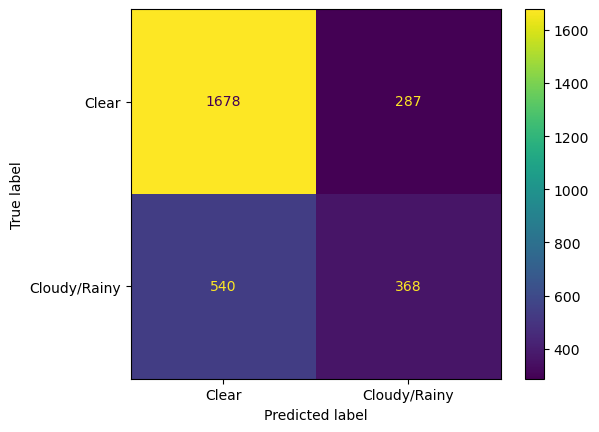

In [198]:
y_predict = bst.predict(dtest)
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    display_labels=["Clear", "Cloudy/Rainy"])

disp.plot()
print("Accuracy: " + str(accuracy_score(y_test, y_predict)))
print("Clear air correctly classified: " + str(cm[0,0]/(cm[0,0] + cm[0,1])))
print("Cloud/Rainy correctly classified: " + str(cm[1,1]/(cm[1,0] + cm[1,1])))

In [199]:
recall = recall_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
f_score = f1_score(y_test, y_predict)
print("Recall = " + str(recall))
print("Precision = " +  str(precision))
print("F1-score = " + str(f_score))

Recall = 0.4052863436123348
Precision = 0.5618320610687023
F1-score = 0.4708893154190659
